In [50]:
import matplotlib.pyplot as plt
import os
import numpy as np


from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator , img_to_array, load_img
from keras.applications.mobilenet import MobileNet, preprocess_input 
from keras.losses import categorical_crossentropy

from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
import tensorflow as tf
from keras.layers import Conv2D,MaxPooling2D

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-883a1b12-5287-6371-57cc-c24174271c04)


In [5]:
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

/device:GPU:0
Num GPUs Available:  1


## Extraindo imagens 

In [7]:
!unzip '/content/drive/MyDrive/data/data.zip' -d '/content/drive/MyDrive/data/'

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /content/drive/MyDrive/data/train/sad/Training_65242339.jpg  
  inflating: /content/drive/MyDrive/data/train/sad/Training_65267116.jpg  
  inflating: /content/drive/MyDrive/data/train/sad/Training_65275626.jpg  
  inflating: /content/drive/MyDrive/data/train/sad/Training_6529266.jpg  
  inflating: /content/drive/MyDrive/data/train/sad/Training_65329617.jpg  
  inflating: /content/drive/MyDrive/data/train/sad/Training_65338712.jpg  
  inflating: /content/drive/MyDrive/data/train/sad/Training_65338797.jpg  
  inflating: /content/drive/MyDrive/data/train/sad/Training_65387162.jpg  
  inflating: /content/drive/MyDrive/data/train/sad/Training_65404494.jpg  
  inflating: /content/drive/MyDrive/data/train/sad/Training_65426218.jpg  
  inflating: /content/drive/MyDrive/data/train/sad/Training_65430136.jpg  
  inflating: /content/drive/MyDrive/data/train/sad/Training_65437377.jpg  
  inflating: /content/drive/MyDrive/data/t

## Validações

In [8]:
train_data_dir='/content/drive/MyDrive/data/train'
validation_data_dir='/content/drive/MyDrive/data/test'

In [25]:
train_datagen = ImageDataGenerator(
					rescale=1./255,
					rotation_range=30,
					shear_range=0.3,
					zoom_range=0.3,
					horizontal_flip=True,
					fill_mode='nearest')


train_data = train_datagen.flow_from_directory(directory= "/content/drive/MyDrive/data/train", 
                                               target_size=(224,224), 
                                               batch_size=32,
                                  )


train_data.class_indices

Found 28709 images belonging to 7 classes.


{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [27]:
validation_datagen = ImageDataGenerator(rescale=1./255)


val_data = validation_datagen.flow_from_directory(directory= "/content/drive/MyDrive/data/test", 
                                           target_size=(224,224), 
                                           batch_size=32,
                                  )


Found 7178 images belonging to 7 classes.


#Visualizando dataset Treino

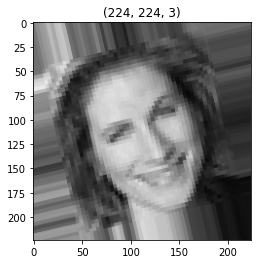

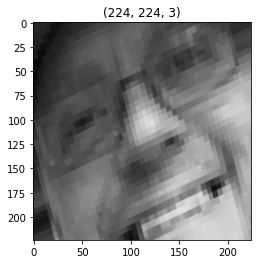

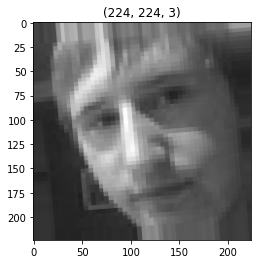

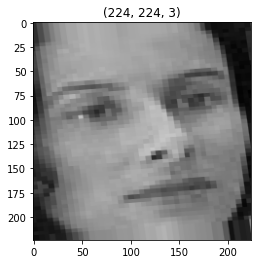

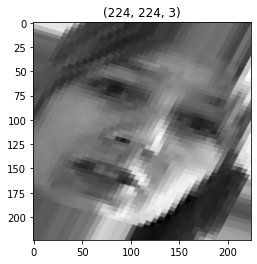

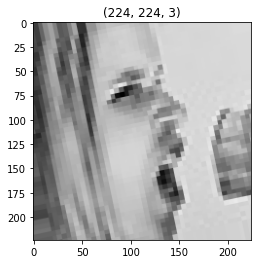

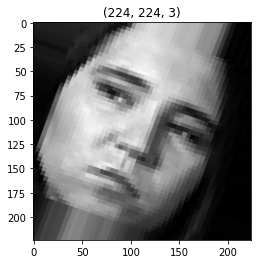

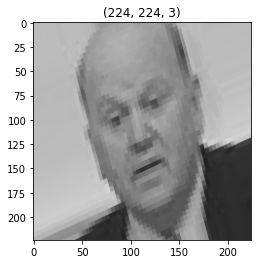

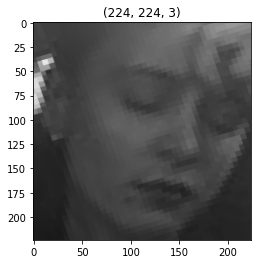

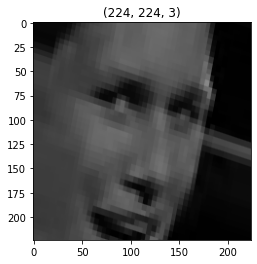

In [28]:
# to visualize the images in the traing data denerator 

t_img , label = train_data.next()

#-----------------------------------------------------------------------------
# function when called will prot the images 
def plotImages(img_arr, label):
  """
  input  :- images array 
  output :- plots the images 
  """
  count = 0
  for im, l in zip(img_arr,label) :
    plt.imshow(im)
    plt.title(im.shape)
    plt.axis = False
    plt.show()
    
    count += 1
    if count == 10:
      break

#-----------------------------------------------------------------------------
# function call to plot the images 
plotImages(t_img, label)

## Criando modelo

In [29]:
train_generator = train_datagen.flow_from_directory(
					train_data_dir,
					color_mode='grayscale',
					target_size=(48, 48),
					batch_size=32,
					class_mode='categorical',
					shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
							validation_data_dir,
							color_mode='grayscale',
							target_size=(48, 48),
							batch_size=32,
							class_mode='categorical',
							shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [30]:
class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']

In [31]:
img, label = train_generator.__next__()


model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(7, activation='softmax'))

model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 22, 22, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                  

In [32]:
train_path = train_data_dir
test_path = validation_data_dir

In [9]:
## Percorrendo as pastas que contém as imagens de treino e teste

num_train_imgs = 0

for root, dirs, files in os.walk(train_path):
    num_train_imgs += len(files)
    
num_test_imgs = 0

for root, dirs, files in os.walk(test_path):
    num_test_imgs += len(files)

print(num_train_imgs)
print(num_test_imgs)

epochs=30

history=model.fit(train_generator,
                steps_per_epoch=num_train_imgs//32,
                epochs=epochs,
                validation_data=validation_generator,
                validation_steps=num_test_imgs//32)

model.save('model_file.h5')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 

## Testando modelo

In [21]:
model = load_model("/content/model_file.h5")

In [22]:
h = history.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

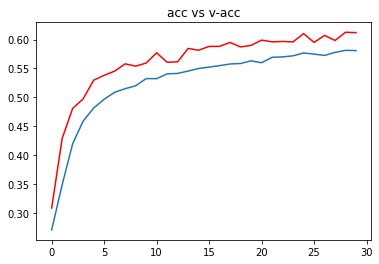

In [23]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'] , c = "red")
plt.title("acc vs v-acc")
plt.show()

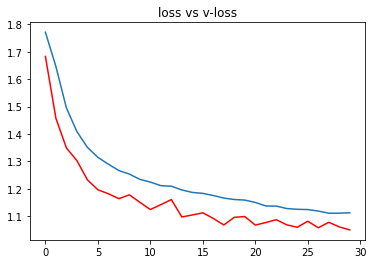

In [24]:
plt.plot(h['loss'])
plt.plot(h['val_loss'] , c = "red")
plt.title("loss vs v-loss")
plt.show()